In [92]:
import tensorflow as tf
from tensorflow import keras

from nn.rolr import dataset, model
from physics.hstar import gghzz, c6
from physics.simulation import msq
from physics.hzz import zpair, angles

import os
import json
import numpy as np
import matplotlib.pyplot as plt

import hist

from sklearn.preprocessing import MinMaxScaler

In [93]:
SEED=373485

BASE_SIZE=10000

OUTPUT_DIR='jobs/rolr/first-tests'
CONF_FILE='rolr-config.json'
SCALER_CONF='scaler.json'
SAMPLE_DIR='..'

In [94]:
with open(os.path.join(OUTPUT_DIR, CONF_FILE), 'r') as conf_file:
    config = json.load(conf_file)

In [95]:
sample_train = gghzz.Process(msq.Component.SIG, (0.1, os.path.join(SAMPLE_DIR, 'ggZZ2e2m_sig.csv'), 1.2*BASE_SIZE))
sample_val = gghzz.Process(msq.Component.SIG, (0.1, os.path.join(SAMPLE_DIR, 'ggZZ2e2m_sig.csv'), config['num_events'] + 1.2*BASE_SIZE))
sample_val.events = sample_val.events[config['num_events']:]

In [96]:
z_chooser = zpair.ZPairChooser(bounds1=(70,115), bounds2=(70,115), algorithm='leastsquare')
kin_vars_train = angles.calculate_2(*sample_train.events.filter(z_chooser))
kin_vars_val = angles.calculate_2(*sample_val.events.filter(z_chooser))

sample_train.events = sample_train.events[:BASE_SIZE]
kin_vars_train = kin_vars_train[:BASE_SIZE]
sample_val.events = sample_val.events[:BASE_SIZE]
kin_vars_val = kin_vars_val[:BASE_SIZE]

In [97]:
c6_values = np.linspace(-20,20,11)

c6_mod_train = c6.Modifier(baseline = msq.Component.SBI, sample=sample_train, c6_values = [-5,-1,0,1,5])
c6_weights_train, c6_prob_train = c6_mod_train.modify(c6=c6_values)

c6_mod_val = c6.Modifier(baseline = msq.Component.SBI, sample=sample_train, c6_values = [-5,-1,0,1,5])
c6_weights_val, c6_prob_val = c6_mod_val.modify(c6=c6_values)

In [98]:
train_set = dataset.build_dataset(x_arr=kin_vars_train, 
                                  param_values=c6_values, 
                                  signal_probabilities=c6_weights_train, 
                                  background_probabilities=sample_train.events.weights)
val_set = dataset.build_dataset(x_arr=kin_vars_val, 
                                param_values=c6_values, 
                                signal_probabilities=c6_weights_val, 
                                background_probabilities=sample_val.events.weights)

In [99]:
with open(os.path.join(OUTPUT_DIR, SCALER_CONF), 'r') as conf_file:
    scaler_conf = json.load(conf_file)

In [100]:
scaler = MinMaxScaler()
scaler.min_ = scaler_conf['scaler.min_']
scaler.scale_ = scaler_conf['scaler.scale_']

train_set = tf.concat([scaler.transform(train_set[:,:10]), train_set[:,10:]], axis=1)
val_set = tf.concat([scaler.transform(val_set[:,:10]), val_set[:,10:]], axis=1)

In [101]:
print(train_set[0])

tf.Tensor(
[7.8102767e-01 9.3859637e-01 2.9386088e-01 9.3281072e-01 6.3171828e-01
 6.7213166e-01 4.2875096e-01 1.7112961e-01 4.8975873e-01 0.0000000e+00
 1.1584735e+01 1.5892517e-06], shape=(12,), dtype=float32)


In [102]:
rolr_model = model.load(os.path.join(OUTPUT_DIR, 'checkpoint.model.tf'))

In [111]:
predictions_train = rolr_model.predict(train_set[:,:10])
predictions_val = rolr_model.predict(val_set[:,:10])

3438/3438 [==============================] - 38s 11ms/step


In [112]:
pred_train_per_c6 = {c6_values[i]: predictions_train[i*BASE_SIZE:(i+1)*BASE_SIZE] for i in range(len(c6_values))}
data_train_per_c6 = {c6_values[i]: train_set[i*BASE_SIZE:(i+1)*BASE_SIZE] for i in range(len(c6_values))}

pred_val_per_c6 = {c6_values[i]: predictions_val[i*BASE_SIZE:(i+1)*BASE_SIZE] for i in range(len(c6_values))}
data_val_per_c6 = {c6_values[i]: val_set[i*BASE_SIZE:(i+1)*BASE_SIZE] for i in range(len(c6_values))}

In [120]:
def generate_histograms(c6_values, data_train_per_c6, pred_train_per_c6, data_val_per_c6, pred_val_per_c6, num_bins):
    histograms = []
    for c6 in c6_values:
        hist_train = hist.Hist(hist.axis.Regular(num_bins, 0, 2, name='x', label='NN output []'))
        hist_train.fill(tf.squeeze(pred_train_per_c6[c6], axis=1))

        hist_val = hist.Hist(hist.axis.Regular(num_bins, 0, 2, name='x', label='NN output []'))
        hist_val.fill(tf.squeeze(pred_val_per_c6[c6], axis=1))

        hist_true = hist.Hist(hist.axis.Regular(num_bins, 0, 600, name='x', label='NN output []'))
        hist_true.fill(data_train_per_c6[c6][:,-2])

        histograms.append((hist_train.to_numpy(), hist_val.to_numpy(), hist_true.to_numpy()))
    
    return histograms

In [124]:
def plot_histograms(c6_values, histograms, colors, xlim=(0.2,0.8)):
    fig = plt.figure(figsize=(7,6))

    for i in range(len(c6_values)):
        plt.step(histograms[i][2][1][1:], histograms[i][2][0], color=colors[i], linestyle='--', label=f'truth (c6={c6_values[i]})', alpha=0.6)
        plt.step(histograms[i][0][1][1:], histograms[i][0][0], color=colors[i], label=f'training data (c6={c6_values[i]})', alpha=0.6)
        plt.scatter(histograms[i][1][1][1:], histograms[i][1][0], s=20, color=colors[i], label=f'validation data (c6={c6_values[i]})', alpha=0.6)

    plt.xlabel('NN output []')
    plt.ylabel('Percentage of predictions []')
    plt.legend()
    plt.xlim(xlim[0],xlim[1])
    plt.yscale('log')

    plt.show()

(10000,)
(10000, 1)


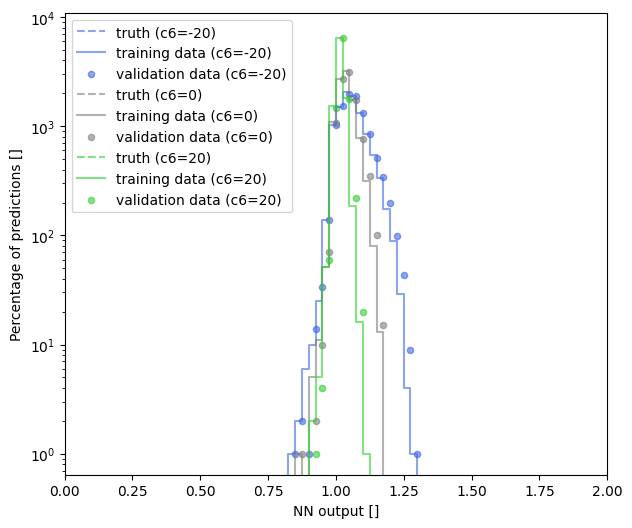

In [126]:
BINS = 80

c6_vals = [-20,0,20]
colors = ['royalblue','gray','limegreen']

print(data_train_per_c6[-20][:,-2].shape)
print(pred_train_per_c6[-20].shape)

histograms = generate_histograms(c6_vals, data_train_per_c6, pred_train_per_c6, data_val_per_c6, pred_val_per_c6, BINS)

plot_histograms(c6_vals, histograms, colors, xlim=(0,2))

(0.0, 2.0)

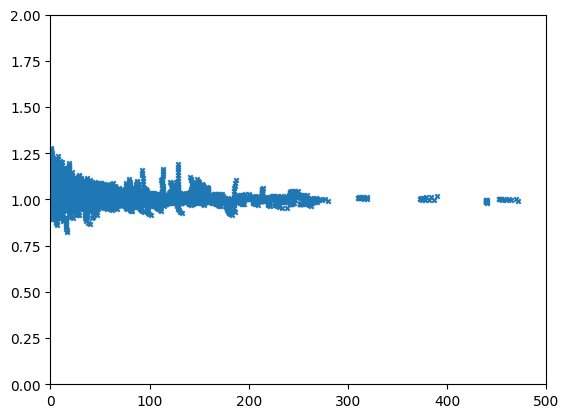

In [116]:
plt.scatter(labels, predictions, s=10, marker='x')
plt.xlim(0,500)
plt.ylim(0,2)